--------------------------
ERP for all raws, left n right
-------------------------

In [ ]:
import mne, os
import numpy as np
import matplotlib.pyplot as plt

raw_folder = os.path.join(os.path.expanduser('~/'),'Desktop', 'FYP', 'code_env', 'eeg-notebooks','FYP', 'data_ordered', 'mne_raw')
raw_files = [file for file in os.listdir(raw_folder) if file.endswith(".fif")]
marker_mapping = {"blue": 1, "red": 2, "right": 3, "left": 4, "right arrow": 5, "left arrow": 6}
duration = 30.0  # Duration of each epoch (seconds)
event_ids = {'left': 4, 'right': 3}  # Replace with your event IDs
tmin, tmax = -0.3, 0.7
evokeds_left = {}
evokeds_right = {}

# Process each raw file and extract evoked response
for file in raw_files:
    if "Audio" in file:
        raw_path = os.path.join(raw_folder, file)
        raw = mne.io.read_raw_fif(raw_path, preload=True)
        events, event_id= mne.events_from_annotations(raw, event_id=marker_mapping)
        filtered_raw = raw.copy().filter(l_freq=0.1, h_freq=40, fir_design='firwin')

        epochs_left = mne.Epochs(filtered_raw, events, event_id=event_ids['left'], tmin=tmin, tmax=tmax,
                             baseline=(None, 0), preload=True)

        # Compute the average evoked response for left events
        evoked_left = epochs_left.average()
        evokeds_left[file] = evoked_left

        # Create epochs based on the events and desired time window for right events
        epochs_right = mne.Epochs(filtered_raw, events, event_id=event_ids['right'], tmin=tmin, tmax=tmax,
                                baseline=(None, 0), preload=True)

        # Compute the average evoked response for right events
        evoked_right = epochs_right.average()
        evokeds_right[file] = evoked_right

# Combine the evoked responses from different trials for left and right events
combined_evoked_left = mne.combine_evoked(list(evokeds_left.values()), weights='nave')
combined_evoked_right = mne.combine_evoked(list(evokeds_right.values()), weights='nave')

# Plot the average evoked responses for left events
fig, ax = plt.subplots()
for evoked in evokeds_left.values():
    ax.plot(evoked.times, evoked.data[0], color='blue', alpha=0.3)
ax.plot(combined_evoked_left.times, combined_evoked_left.data[0], color='blue', label='Left')
ax.set(xlabel='Time (s)', ylabel='Amplitude (uV)', title='Average Evoked Response for Left Events')
ax.legend(loc='upper right')
plt.show()


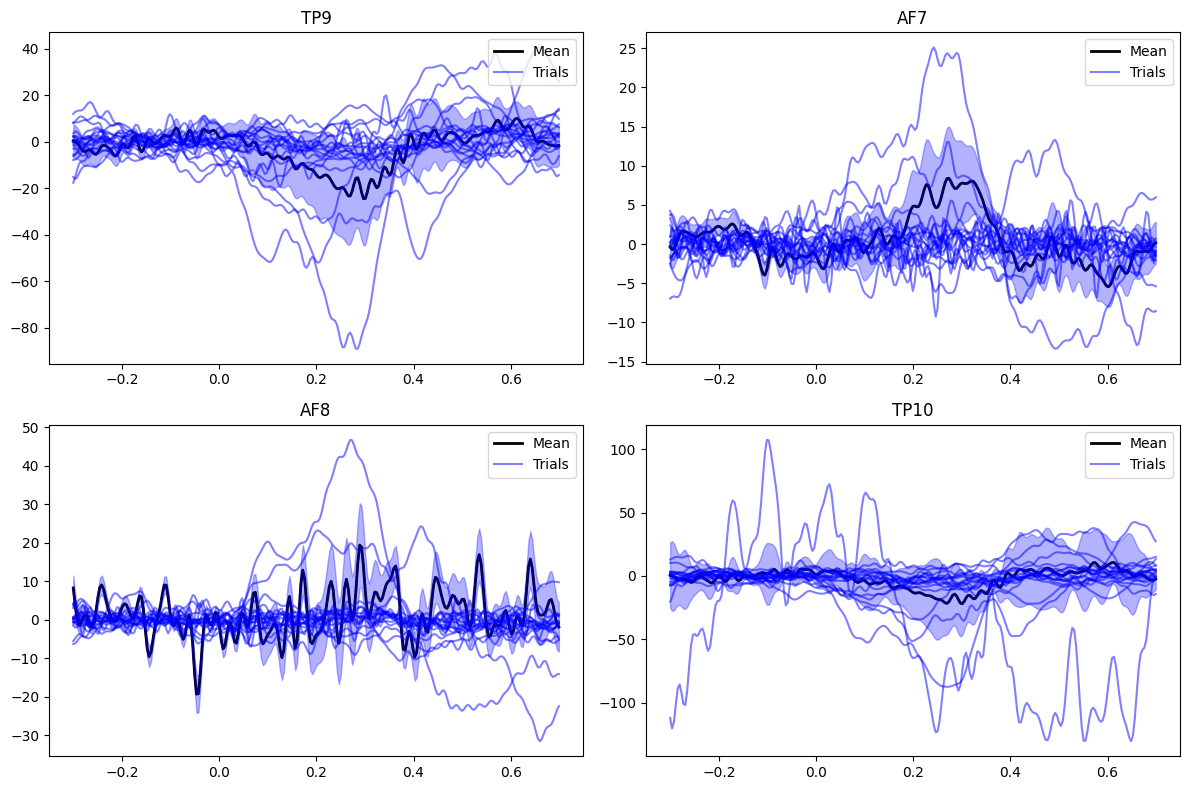

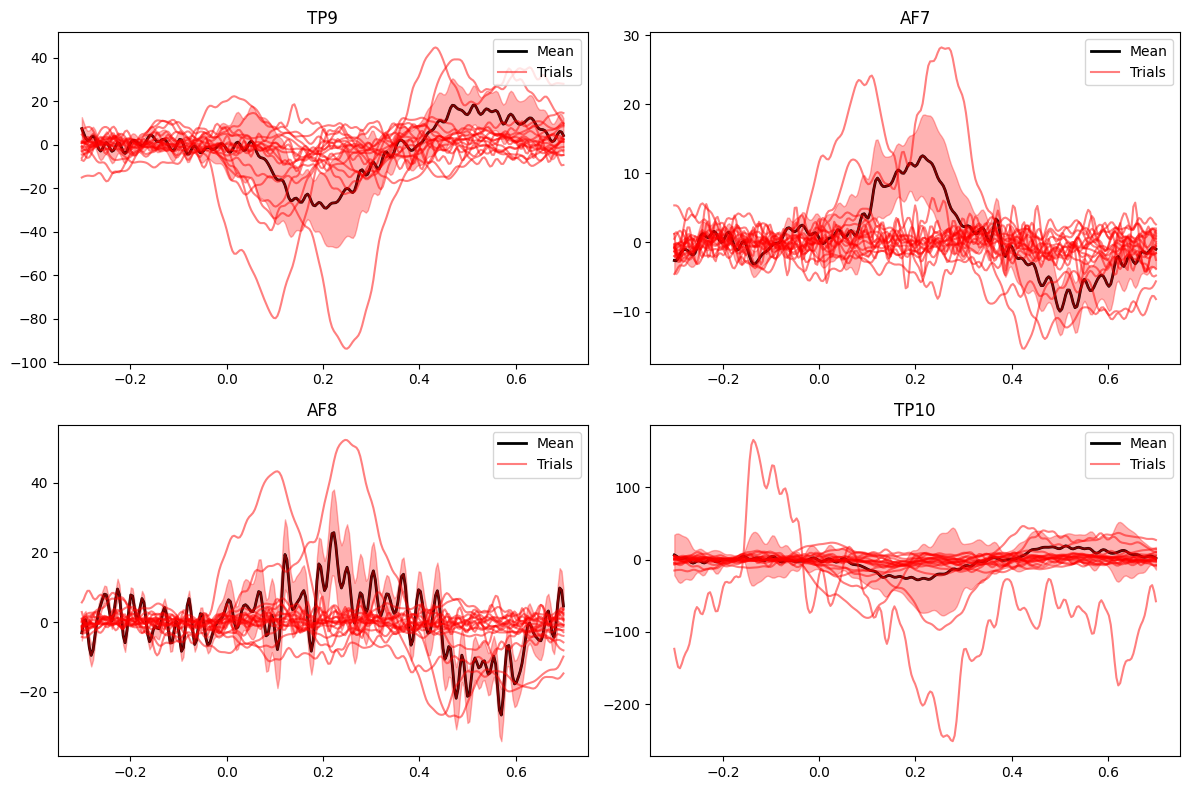

In [17]:
# Plot the average evoked response, individual trials, and standard deviation for each channel for left events
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ch_idx, ch_name in enumerate(evoked_left.ch_names):
    row_idx = ch_idx // 2
    col_idx = ch_idx % 2

    axs[row_idx, col_idx].plot(evoked_left.times, evoked_left.data[ch_idx], color='black', linewidth=2, label='Mean')
    axs[row_idx, col_idx].set_title(ch_name)
    axs[row_idx, col_idx].fill_between(evoked_left.times,
                                       evoked_left.data[ch_idx] - np.std([evoked.data[ch_idx] for evoked in evokeds_left.values()], axis=0),
                                       evoked_left.data[ch_idx] + np.std([evoked.data[ch_idx] for evoked in evokeds_left.values()], axis=0),
                                       color='blue', alpha=0.3)

    for raw_file, evoked in evokeds_left.items():
        if raw_file == list(evokeds_left.keys())[0]:
            axs[row_idx, col_idx].plot(evoked.times, evoked.data[ch_idx], color='blue', alpha=0.5, label='Trials')
        else:
            axs[row_idx, col_idx].plot(evoked.times, evoked.data[ch_idx], color='blue', alpha=0.5)

    axs[row_idx, col_idx].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Plot the average evoked response, individual trials, and standard deviation for each channel for right events
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ch_idx, ch_name in enumerate(evoked_right.ch_names):
    row_idx = ch_idx // 2
    col_idx = ch_idx % 2

    axs[row_idx, col_idx].plot(evoked_right.times, evoked_right.data[ch_idx], color='black', linewidth=2, label='Mean')
    axs[row_idx, col_idx].set_title(ch_name)
    axs[row_idx, col_idx].fill_between(evoked_right.times,
                                       evoked_right.data[ch_idx] - np.std([evoked.data[ch_idx] for evoked in evokeds_right.values()], axis=0),
                                       evoked_right.data[ch_idx] + np.std([evoked.data[ch_idx] for evoked in evokeds_right.values()], axis=0),
                                       color='red', alpha=0.3)

    for raw_file, evoked in evokeds_right.items():
        if raw_file == list(evokeds_right.keys())[0]:
            axs[row_idx, col_idx].plot(evoked.times, evoked.data[ch_idx], color='red', alpha=0.5, label='Trials')
        else:
            axs[row_idx, col_idx].plot(evoked.times, evoked.data[ch_idx], color='red', alpha=0.5)

    axs[row_idx, col_idx].legend(loc='upper right')

plt.tight_layout()
plt.show()